# Постановка задачи

Создать модели линейной регрессии для предсказания стоимости квартир.

Сравнить получившиеся коэффициенты классической линейной регрессии с коэффициентами при признаках в байесовской линейной регрессии.

## Анализ данных и распределений признаков

In [83]:
# загружаем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import pymc as pm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [63]:
# загружаем датасет
flats = pd.read_csv('flats.csv')
flats.head()

,Unnamed: 0,price_doc,full_sq,life_sq,num_room,kitch_sq
0,8056,2750000,11,11.0,1.0,12.0
1,8154,7100000,45,27.0,2.0,6.0
2,8287,11700000,77,50.0,3.0,8.0
3,8387,10400000,56,29.0,2.0,10.0
4,8391,6200000,31,21.0,1.0,5.0


In [64]:
# проверяем пропуски и типы данных
flats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6042 entries, 0 to 6041
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6042 non-null   int64  
 1   price_doc   6042 non-null   int64  
 2   full_sq     6042 non-null   int64  
 3   life_sq     6042 non-null   float64
 4   num_room    6042 non-null   float64
 5   kitch_sq    6042 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 283.3 KB


In [65]:
# есть подозрение, что признак 'Unnamed: 0' неинформативный
flats['Unnamed: 0'].nunique()

6042

In [66]:
# выведем описательные статистики
flats.describe()

,Unnamed: 0,price_doc,full_sq,life_sq,num_room,kitch_sq
count,6042.000000,6.042000e+03,6042.000000,6042.000000,6042.000000,6042.000000
mean,19846.990070,8.750423e+06,53.374545,33.198941,1.997021,7.391096
std,6081.011373,6.277290e+06,24.011941,20.190005,0.889523,3.806198
min,8056.000000,5.000000e+05,1.000000,0.000000,0.000000,0.000000
25%,14573.250000,5.800000e+06,38.000000,20.000000,1.000000,5.000000
50%,19871.500000,7.400000e+06,46.000000,29.000000,2.000000,7.000000
75%,25147.750000,1.050000e+07,63.000000,42.000000,3.000000,9.000000
max,30470.000000,9.512250e+07,637.000000,637.000000,17.000000,96.000000


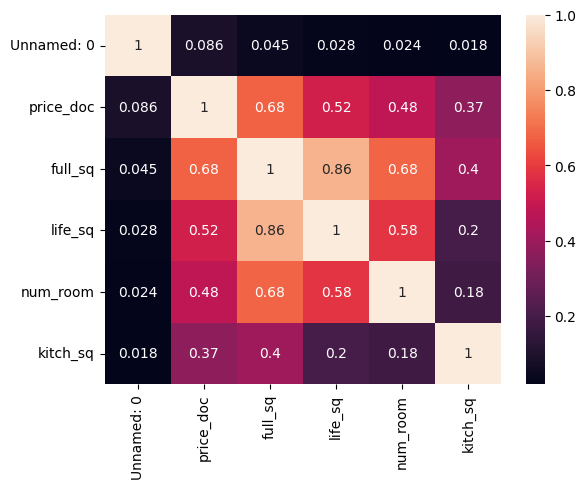

In [67]:
# проверим корреляцию признаков
sns.heatmap(flats.corr(), annot = True);

Признаки full_sq, life_sq и num_room коррелируют. С помощью метода главных компонент создадим из них 1 признак flat_size.

In [68]:
pca = PCA(n_components = 1)
flats['flat_size'] = pca.fit_transform(
    flats[['full_sq', 'life_sq', 'num_room']]
)

Проанализируем распределения целевой переменной и признаков, с которыми будем работать.

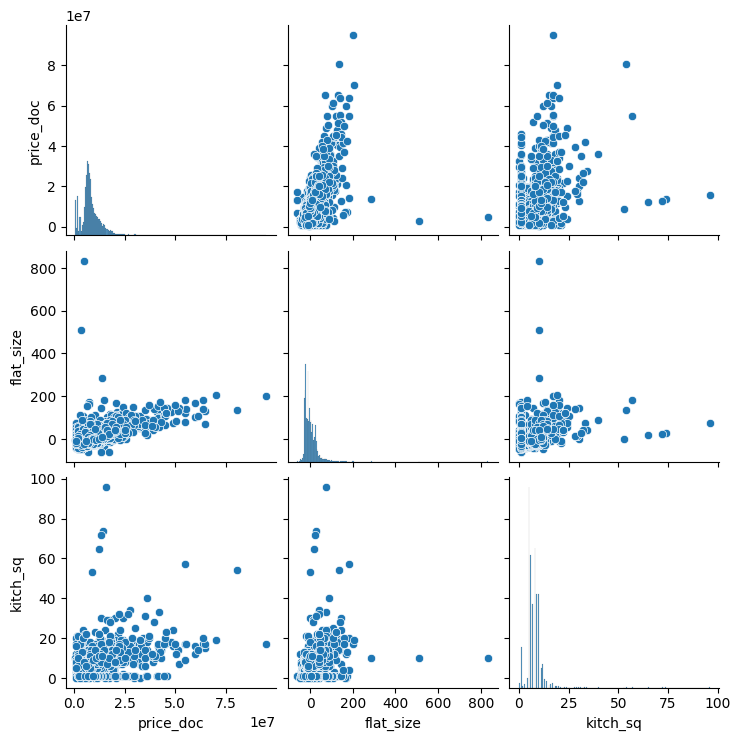

In [69]:
sns.pairplot(flats[['price_doc', 'flat_size', 'kitch_sq']]);

Лучше работать с целевой переменной, применив к ней логарифм. После предсказания значение можно будет перевести обратно, сделав степенью экспоненты.

Признаки, с которыми будем работать - стандартизируем.

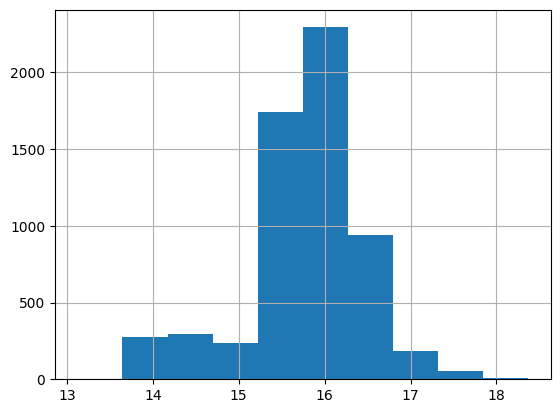

In [70]:
# логарифмируем целевую переменную
flats['price_log'] = np.log(flats['price_doc'])

# стандартизируем признаки
flats['size_scaled'] = StandardScaler().fit_transform(
    flats[['flat_size']].values
)
flats['kitch_scaled'] = StandardScaler().fit_transform(
    flats[['kitch_sq']].values
)

# посмотрим на получившееся распределение целевой переменной
flats['price_log'].hist();

## Байесовская линейная регрессия

In [73]:
# построение модели
bayes_model = pm.Model()

with bayes_model:
    # приоры для неизвестных параметров модели
    Intercept = pm.Normal('Intercept', mu = 0, sigma = 100)
    size_scaled = pm.Normal('size_scaled', mu = 0, sigma = 100)
    kitch_scaled = pm.Normal('kitch_scaled', mu = 0, sigma = 100)

    # ожидаемое значение переменной
    mu = (
        Intercept
        + size_scaled * flats['size_scaled'].values
        + kitch_scaled * flats['kitch_scaled'].values
    )

    # вероятность (выборочное распределение) наблюдений
    likelihood = pm.Normal('likelihood', mu = mu, observed = flats['price_log'])

    # получаем 3000 объектов из апостериорного распределения
    trace = pm.sample(3000)

Output()

Output()

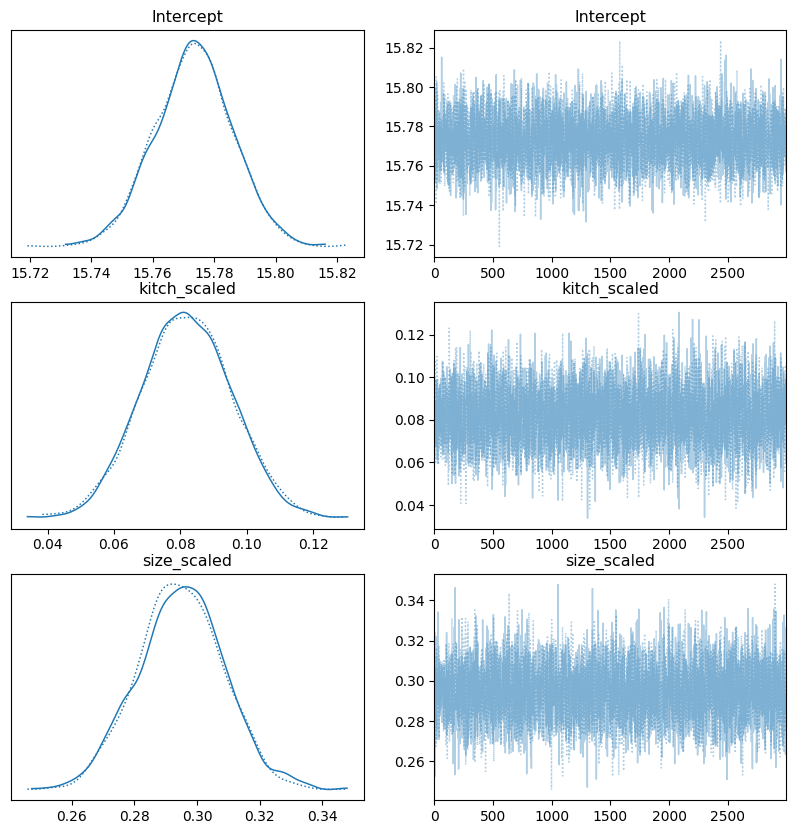

In [79]:
# распределение апостериорных вероятностей параметров
pm.plot_trace(trace, figsize = (10, 10));

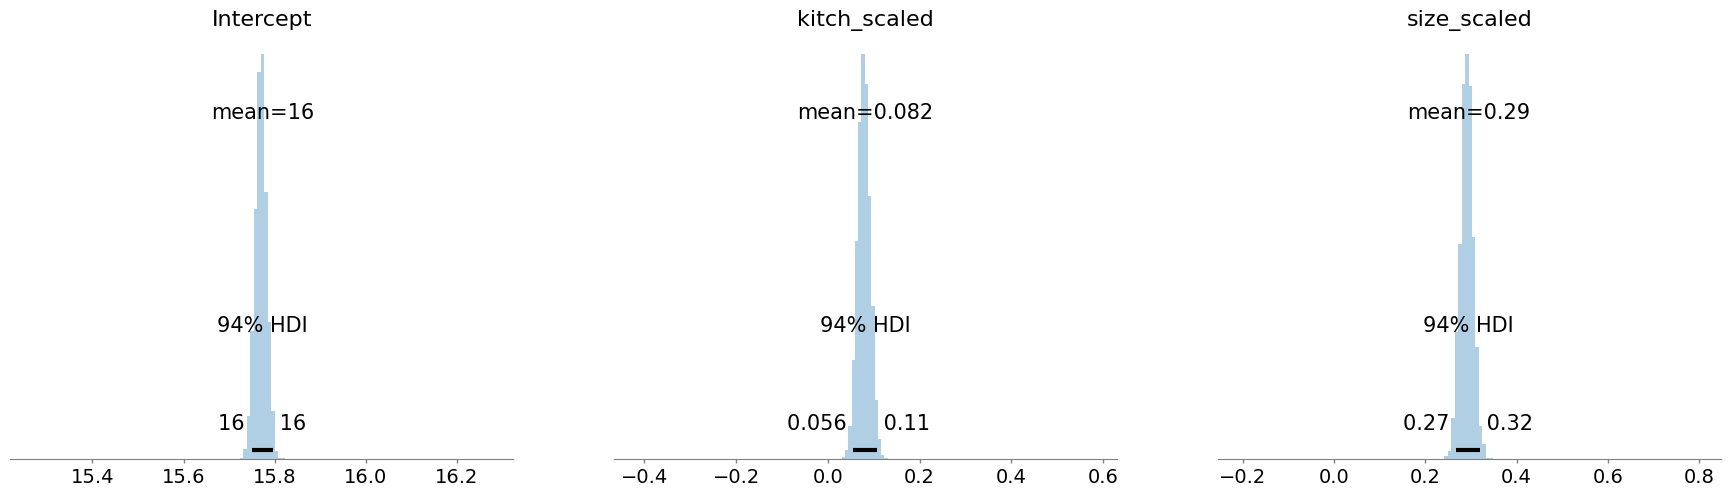

In [80]:
# гистограммы апостериорных вероятностей параметров
pm.plot_posterior(trace, kind = 'hist');

In [81]:
# сводка
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,15.773,0.013,15.750,15.797,0.0,0.0,8247.0,4828.0,1.0
kitch_scaled,0.082,0.014,0.056,0.106,0.0,0.0,7782.0,4537.0,1.0
size_scaled,0.295,0.014,0.268,0.319,0.0,0.0,7173.0,4969.0,1.0


## Линейная регрессия из sklearn

In [91]:
# построение линейной регресси
lr_model = LinearRegression()
lr_model.fit(flats[['kitch_scaled', 'size_scaled']], flats['price_log'])

# выводим коэффициенты
print('Intercept:', round(lr_model.intercept_, 3))
pd.DataFrame(
    np.round(lr_model.coef_, 3),
    index = ['kitch_scaled', 'size_scaled']
)

Intercept: 15.773


,0
kitch_scaled,0.082
size_scaled,0.295


## Вывод

Коэффициенты совпадают.